In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
application_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
application_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv')

In [3]:
def agg_numeric(df, group_var, df_name):
    numeric_df = df.select_dtypes('number')
    numeric_df = numeric_df.groupby(group_var).agg(['mean', 'sum','max','min','count']).reset_index()
    
    columns = [group_var]
    for var in numeric_df.columns.levels[0]:
        if var != group_var:
            for stat in numeric_df.columns.levels[1][:-1]:
                columns.append('%s_%s_%s'%(df_name, var, stat))
    numeric_df.columns = columns
    return numeric_df

def count_categorical(df, group_var, df_name):
    categorical_df = pd.get_dummies(df.select_dtypes('object'))
    categorical_df[group_var] = df[group_var]
    
    categorical_df = categorical_df.groupby(group_var).agg(['sum','mean'])
    
    columns = []
    
    for var in categorical_df.columns.levels[0]:
        for stat in ['count','mean']:
            columns.append('%s_%s_%s'%(df_name, var, stat))
    categorical_df.columns = columns
    return categorical_df

In [4]:
bureau_agg = agg_numeric(bureau.drop(columns ='SK_ID_BUREAU'), 'SK_ID_CURR', 'bureau')
bureau_count = count_categorical(bureau.drop(columns ='SK_ID_BUREAU'), 'SK_ID_CURR', 'bureau')
bureau_balance_agg = agg_numeric(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
bureau_balance_count = count_categorical(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')

In [5]:
bureau_balance_by_bureau = bureau_balance_agg.merge(bureau_balance_count, left_on ='SK_ID_BUREAU', right_index= True, how = 'outer')
bureau_balance_by_client = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']].merge(bureau_balance_by_bureau, on = 'SK_ID_BUREAU', how = 'left')
bureau_balance_by_client = agg_numeric(bureau_balance_by_client.drop(columns='SK_ID_BUREAU'),'SK_ID_CURR', 'client')

In [6]:
train = application_train.merge(bureau_count, on ='SK_ID_CURR', how='left')
train = train.merge(bureau_agg, on ='SK_ID_CURR', how='left')
train = train.merge(bureau_balance_by_client, on ='SK_ID_CURR', how='left')

In [7]:
test = application_test.merge(bureau_count, on ='SK_ID_CURR', how='left')
test = test.merge(bureau_agg, on ='SK_ID_CURR', how='left')
test = test.merge(bureau_balance_by_client, on ='SK_ID_CURR', how='left')

In [8]:
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Training Data Shape: (307511, 333)
Testing Data Shape: (48744, 332)


In [9]:
train_labels = train['TARGET']
train, test= train.align(test, join='inner', axis = 1)
train['TARGET'] = train_labels 

In [10]:
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Training Data Shape: (307511, 333)
Testing Data Shape: (48744, 332)


In [11]:
train.to_csv('train_bureau.csv', index = False)
test.to_csv('test_bureau.csv', index = False)

## Feature Engineering

In [12]:
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_mean_mean,client_bureau_balance_STATUS_X_mean_sum,client_bureau_balance_STATUS_X_mean_max,client_bureau_balance_STATUS_X_mean_min,client_bureau_balance_STATUS_X_mean_count,TARGET
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,15.0,3.0,0.0,8.0,0.161932,1.295455,0.5,0.0,8.0,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,NaN,NaN,0.0,NaN,0.000000,NaN,NaN,0.0,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.0,NaN,NaN,0.0,NaN,0.000000,NaN,NaN,0.0,0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.0,NaN,NaN,0.0,NaN,0.000000,NaN,NaN,0.0,0


In [13]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [14]:
def feature_engineering(df):
    df = df[df['CODE_GENDER'] != 'XNA']
    df = df[df['AMT_INCOME_TOTAL'] < 2000000]
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
    
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].sum(axis=1)
    
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))
    
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCE_WEIGHT'] = df['EXT_SOURCE_1']*2 + df['EXT_SOURCE_2'] *1 + df['EXT_SOURCE_3'] *3
    
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    # Time ratios
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    
    df = df.reset_index(drop=True)
    return df

In [15]:
train_feature_engineered = feature_engineering(train)
test_feature_engineered = feature_engineering(test)
print('Training data shape: ', train_feature_engineered.shape)
print('Testing data shape: ', test_feature_engineered.shape)

Training data shape:  (307463, 354)
Testing data shape:  (48739, 353)


In [16]:
train_feature_engineered.to_csv('train_feature_engineered.csv', index = False)
test_feature_engineered.to_csv('test_feature_engineered.csv', index = False)

In [17]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc
import matplotlib.pyplot as plt

In [18]:
def model(features, test_features, encoding = 'ohe', n_folds =5):
    labels = features['TARGET']
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    train = features.drop(columns = ['TARGET','SK_ID_CURR'])
    test = test_features.drop(columns = 'SK_ID_CURR')
    
    if encoding == 'ohe':
        train = pd.get_dummies(train)
        test = pd.get_dummies(test)
        
        train, test = train.align(test, join='inner', axis =1)
        cat_indices = 'auto'
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        cat_indices = []
        
        for i, col in enumerate(train):
            if train[col] == 'object':
                train[col] = label_encoder.fit_transform(np.array(train[col].astype(str)).reshape(-1,))
                test[col] = label_encoder.transform(np.array(test[col].astype(str)).reshape(-1,))
                cat_indices.append(i)
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    print('Traing Data Shape:', train.shape)
    print('Testing Data Shape:', test.shape)
    
    feature_names = list(train.columns)
    
    train = np.array(train)
    test = np.array(test)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    feature_importance_values = np.zeros(len(feature_names))
    
    test_predictions = np.zeros(len(test))
    out_of_fold = np.zeros(len(train))
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(train):
        train_features, train_labels = train[train_indices], labels[train_indices]
        valid_features, valid_labels = train[valid_indices], labels[valid_indices]
        
        model = lgb.LGBMClassifier(n_estimators = 10000
                                   , objective='binary'
                                   , class_weight = 'balanced'
                                   , learning_rate = 0.05
                                   , reg_alpha = 0.1
                                   , reg_lambda = 0.1
                                   , subsample = 0.8
                                   , n_jobs = -1
                                   , random_state= 50
                                  )
        model.fit(train_features
                 , train_labels
                 , eval_metric = 'auc'
                 , eval_set = [(valid_features, valid_labels), (train_features, train_labels)]
                 , eval_names =['valid','train']
                 , categorical_feature = cat_indices
                 , early_stopping_rounds = 100
                 , verbose = 200
        )
        best_iteration = model.best_iteration_
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        test_predictions += model.predict_proba(test, num_iteration = best_iteration)[:,1] / k_fold.n_splits
        
        out_of_fold[valid_indices] =model.predict_proba(valid_features, num_iteration = best_iteration)[:,1]
        
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    feature_importacne = pd.DataFrame({'feature':feature_names, 'importance':feature_importance_values})
    
    submission = pd.DataFrame({'SK_ID_CURR':test_ids, 'TARGET':test_predictions})
    
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold':fold_names, 'train':train_scores, 'valid': valid_scores})
    return submission, feature_importacne, metrics

In [19]:
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending = False).reset_index()
    
    df['importance_nomalized'] = df['importance'] / df['importance'].sum()
    
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_nomalized'].head(15),
           align = 'center',
           edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance')
    plt.ylabel('Feature Importances')
    plt.show()
    
    return df

In [20]:
submission, fi, metrics = model(train,test)

Traing Data Shape: (307511, 452)
Testing Data Shape: (48744, 452)
[200]	train's auc: 0.810821	train's binary_logloss: 0.53617	valid's auc: 0.763278	valid's binary_logloss: 0.553135
[200]	train's auc: 0.810727	train's binary_logloss: 0.53666	valid's auc: 0.765248	valid's binary_logloss: 0.553447
[200]	train's auc: 0.809569	train's binary_logloss: 0.538079	valid's auc: 0.770518	valid's binary_logloss: 0.554759
[200]	train's auc: 0.810367	train's binary_logloss: 0.537096	valid's auc: 0.765831	valid's binary_logloss: 0.552573
[200]	train's auc: 0.810433	train's binary_logloss: 0.536726	valid's auc: 0.76417	valid's binary_logloss: 0.554751


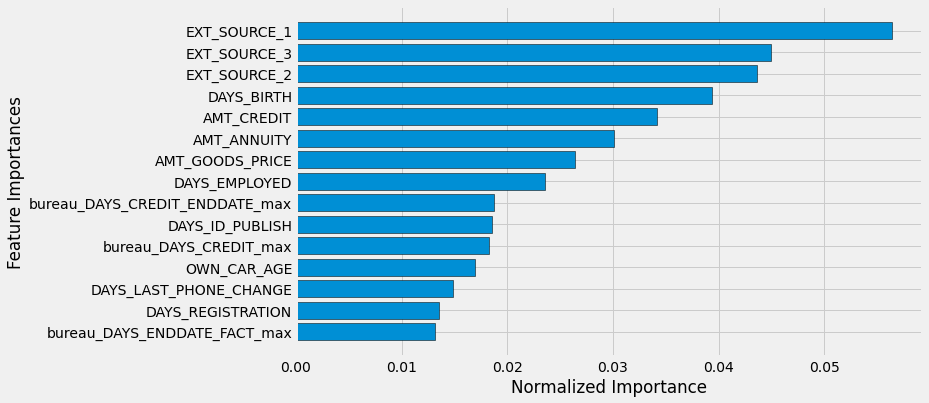

,index,feature,importance,importance_nomalized
0,27,EXT_SOURCE_1,452.8,0.056445
1,29,EXT_SOURCE_3,360.4,0.044926
2,28,EXT_SOURCE_2,350.0,0.043630
3,6,DAYS_BIRTH,315.8,0.039367
4,2,AMT_CREDIT,274.4,0.034206
...,...,...,...,...
447,135,bureau_CREDIT_TYPE_Loan for purchase of shares...,0.0,0.000000
448,325,NAME_TYPE_SUITE_Group of people,0.0,0.000000
449,322,FLAG_OWN_REALTY_Y,0.0,0.000000
450,134,bureau_CREDIT_TYPE_Loan for purchase of shares...,0.0,0.000000


In [21]:
plot_feature_importances(fi)

In [22]:
metrics

,fold,train,valid
0,0,0.823660,0.763730
1,1,0.824682,0.766092
2,2,0.826798,0.771362
3,3,0.817720,0.766207
4,4,0.821525,0.764642
5,overall,0.822877,0.766404


In [23]:
submission_engineered, fi_engineered, metrics_engineered = model(train_feature_engineered, test_feature_engineered)

Traing Data Shape: (307463, 473)
Testing Data Shape: (48739, 473)
[200]	train's auc: 0.815659	train's binary_logloss: 0.530203	valid's auc: 0.771883	valid's binary_logloss: 0.546744
[200]	train's auc: 0.815998	train's binary_logloss: 0.529594	valid's auc: 0.770062	valid's binary_logloss: 0.546099
[400]	train's auc: 0.850903	train's binary_logloss: 0.492664	valid's auc: 0.77065	valid's binary_logloss: 0.523572
[200]	train's auc: 0.815952	train's binary_logloss: 0.529834	valid's auc: 0.77381	valid's binary_logloss: 0.547175
[400]	train's auc: 0.85105	train's binary_logloss: 0.492922	valid's auc: 0.775925	valid's binary_logloss: 0.523701
[200]	train's auc: 0.815944	train's binary_logloss: 0.529744	valid's auc: 0.768323	valid's binary_logloss: 0.552721
[400]	train's auc: 0.851144	train's binary_logloss: 0.492664	valid's auc: 0.769775	valid's binary_logloss: 0.529509
[200]	train's auc: 0.814885	train's binary_logloss: 0.530791	valid's auc: 0.775488	valid's binary_logloss: 0.547882
[400]	tra

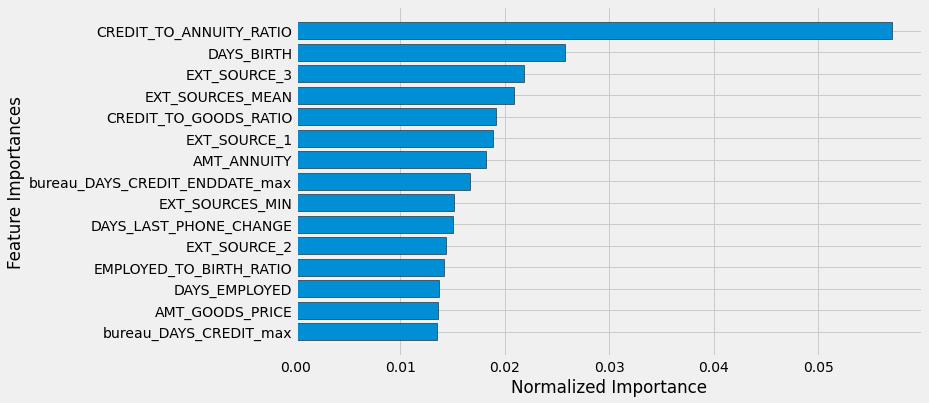

,index,feature,importance,importance_nomalized
0,325,CREDIT_TO_ANNUITY_RATIO,595.2,0.057077
1,6,DAYS_BIRTH,268.8,0.025777
2,29,EXT_SOURCE_3,227.8,0.021845
3,322,EXT_SOURCES_MEAN,217.2,0.020829
4,326,CREDIT_TO_GOODS_RATIO,200.2,0.019198
...,...,...,...,...
468,346,NAME_TYPE_SUITE_Group of people,0.0,0.000000
469,347,NAME_TYPE_SUITE_Other_A,0.0,0.000000
470,254,client_bureau_balance_STATUS_1_mean_count,0.0,0.000000
471,348,NAME_TYPE_SUITE_Other_B,0.0,0.000000


In [24]:
plot_feature_importances(fi_engineered)

In [25]:
metrics_engineered

,fold,train,valid
0,0,0.827294,0.772525
1,1,0.838932,0.770862
2,2,0.858705,0.776032
3,3,0.847241,0.769914
4,4,0.838210,0.776313
5,overall,0.842076,0.773072
